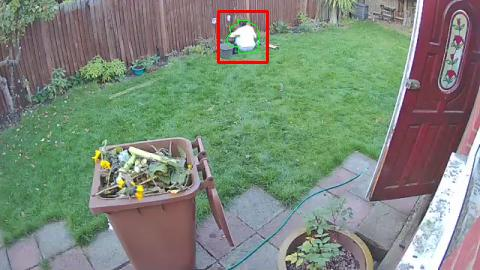

In [ ]:
# ==============================================================================
# IMPORTS AND INITIAL SETUP
# ==============================================================================
import os, cv2, time, numpy as np
from collections import deque
from datetime import datetime
from IPython.display import display, Image as IPyImage, clear_output
import threading
from queue import Queue
import socket
from PIL import Image
import hid
import torch
from transformers import CLIPModel, CLIPProcessor
# ==============================================================================
# RELAY & SPRINKLER CONFIG
# ==============================================================================
VENDOR_ID = 0x16c0
PRODUCT_ID = 0x05df
RELAY_TO_CONTROL = 1
RELAY_ON_COMMAND = [0x00, 0xFF, RELAY_TO_CONTROL, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
RELAY_OFF_COMMAND = [0x00, 0xFD, RELAY_TO_CONTROL, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00]
sprinkler_lock = threading.Lock()
max_crop_fraction = 0.15

cv2.destroyAllWindows()
cv2.waitKey(1)

try:
    hq.stop()
except:
    pass

def sprinkler_on(t=30):
    if not sprinkler_lock.acquire(blocking=False):
        print("-> Sprinkler command ignored: An operation is already in progress.")
        return
    device = None
    try:
        print(f"-> Thread started: Opening device with VID=0x{VENDOR_ID:04x} PID=0x{PRODUCT_ID:04x}")
        device = hid.device()
        device.open(VENDOR_ID, PRODUCT_ID)
        print("-> Device opened successfully.")
        print(f"-> Sending ON command to relay #{RELAY_TO_CONTROL} for {t} seconds...")
        device.send_feature_report(RELAY_ON_COMMAND)
        time.sleep(0.1)
        print("-> Relay should be ON.")
        time.sleep(t)
        print(f"-> Sending OFF command to relay #{RELAY_TO_CONTROL}...")
        device.send_feature_report(RELAY_OFF_COMMAND)
        time.sleep(0.1)
        print("-> Relay should be OFF.")
    except Exception as e:
        print(f"-> Sprinkler error: {e}")
    finally:
        if device:
            device.close()
            print("-> Device closed.")
        sprinkler_lock.release()
        print("-> Sprinkler thread finished and lock released.")

# ==============================================================================
# TINYCLIP MODEL SETUP
# ==============================================================================
# --- Configuration ---
MODEL_ID = "wkcn/TinyCLIP-ViT-39M-16-Text-19M-YFCC15M"

# --- Device Selection ---
print("Setting up AI model...")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Load Model and Processor ---
processor = CLIPProcessor.from_pretrained(MODEL_ID)
model = CLIPModel.from_pretrained(MODEL_ID)
model.to(DEVICE)
model.eval()
print(f"Model '{MODEL_ID}' loaded and ready.")

# --- Prompts and Thresholds ---
n_people_decoys = 6
PROMPTS = [
    "man", "woman", "a person walking", "a photograph of a person",
    "people", "person wearing a jumper", "a photograph of a fox",
    "a photograph of a frog", "an empty garden at night", "a car", 'grass', 'empty', 'nothing', 'plants',
    'blurry image of nothing', 'a photograph of a cat', 'field', 'desert',
    "a blurry shadow moving on the ground", "a blurry shape moving quickly",
    "a garden chair", "photograph of a metal chair", "photograph of a door"
]
FOX_SCORE_THRESHOLD = 0.14
people_sum_thresh = 0.2

# ==============================================================================
# ✨ NEW: PRE-COMPUTE TEXT EMBEDDINGS (THE OPTIMIZATION) ✨
# ==============================================================================
print("Pre-computing text embeddings for all prompts...")
# Tokenize the prompts and move them to the selected device
text_inputs = processor(text=PROMPTS, return_tensors="pt", padding=True).to(DEVICE)

# Generate the text embeddings (features) once
with torch.no_grad():
    precomputed_text_features = model.get_text_features(**text_inputs)
    # Normalize the features for cosine similarity calculation
    precomputed_text_features /= precomputed_text_features.norm(dim=-1, keepdim=True)
print("Text embeddings are ready.")


# ==============================================================================
# NETWORKING & CAMERA SETUP
# ==============================================================================
import gc, cv2, psutil, os, time

import psutil, os, socket

def force_close_rtsp_sockets(verbose=True):
    proc = psutil.Process(os.getpid())
    closed = 0
    for c in proc.connections(kind='inet'):
        if c.raddr and c.raddr.port == 554:
            try:
                s = socket.socket(fileno=c.fd)
                s.close()
                closed += 1
            except Exception:
                pass
    if verbose:
        print(f"🔪 Force-closed {closed} RTSP socket(s).")


def cleanup_stale_opencv_sessions(verbose=True):
    """
    Tries to close any leftover RTSP/VideoCapture sessions that may block new connections.
    Safe to call repeatedly, even between cell re-runs.
    """
    if verbose:
        print("🧹 Cleaning up stale OpenCV RTSP sessions...")

    try:
        # Forcefully destroy OpenCV windows and internal GUI handles
        cv2.destroyAllWindows()
        cv2.waitKey(1)
    except Exception as e:
        if verbose:
            print(f"  cv2 cleanup warning: {e}")

    # Force garbage collection to trigger __del__ on any VideoCapture objects
    gc.collect()

    # Small delay to give OS a chance to close sockets
    time.sleep(0.3)

    # Optional: check for open RTSP sockets and warn
    try:
        proc = psutil.Process(os.getpid())
        connections = [c for c in proc.connections(kind='inet') if c.laddr.port != 0]
        rtsp_conns = [c for c in connections if c.raddr and c.raddr.port == 554]
        if rtsp_conns:
            if verbose:
                print(f"⚠️  Warning: {len(rtsp_conns)} RTSP socket(s) still open — camera may be locked.")
            for c in rtsp_conns:
                if verbose:
                    print(f"   -> {c.raddr.ip}:{c.raddr.port} (status={c.status})")
        else:
            if verbose:
                print("✅ No RTSP sockets detected — safe to reconnect.")
    except Exception as e:
        if verbose:
            print(f"  Could not inspect network connections: {e}")

    if verbose:
        print("🧽 Cleanup complete.\n")


def _check_port(ip, port, timeout=0.5):
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(timeout)
    try:
        return sock.connect_ex((ip, port)) == 0
    finally:
        sock.close()

def find_camera_ip(default_ip='192.168.68.102', subnet='192.168.68', port=554):
    if default_ip and _check_port(default_ip, port):
        print(f"✅ Success! Camera found at the last known IP: {default_ip}")
        return default_ip
    print(f"🐢 Scanning subnet {subnet}.x for a camera on port {port}...")
    for i in range(1, 255):
        ip = f"{subnet}.{i}"
        print(f"\rChecking: {ip}  ", end="")
        if _check_port(ip, port):
            print(f"\n✅ Found new camera IP at: {ip}")
            return ip
    print("\n❌ Camera not found on this subnet.")
    return None

USER = "foxyfoxy"
PASS = "foxyfoxy123"
IP = find_camera_ip(subnet='192.168.68')
if not IP:
    raise RuntimeError("Could not find camera. Exiting.")

RTSP_LOW  = f"rtsp://{USER}:{PASS}@{IP}:554/stream2"
RTSP_HIGH = f"rtsp://{USER}:{PASS}@{IP}:554/stream1"
os.environ["OPENCV_FFMPEG_CAPTURE_OPTIONS"] = "rtsp_transport;tcp|max_delay;0|stimeout;5000000"


# ==============================================================================
# UTILITIES AND HELPER CLASSES (UNCHANGED)
# ==============================================================================
# Your helper functions (ensure_dir, timestamp_str, make_mask, etc.) and
# classes (HQSampler, FileWriter) go here. They don't need to be changed.


def is_grayscale(img, tolerance=15):
    """Checks if an image is grayscale by comparing its color channels."""
    # If the image has no color channels, it's grayscale
    if len(img.shape) < 3: return True
    if img.shape[2] == 1: return True
    
    # Calculate the mean absolute difference between the blue/green and green/red channels
    b_g_diff = np.mean(np.abs(img[:,:,0].astype(int) - img[:,:,1].astype(int)))
    g_r_diff = np.mean(np.abs(img[:,:,1].astype(int) - img[:,:,2].astype(int)))
    
    # If the differences are small, it's a grayscale image
    return (b_g_diff < tolerance) and (g_r_diff < tolerance)
    
def ensure_dir(p):
    if not os.path.isdir(p):
        os.makedirs(p, exist_ok=True)
def timestamp_str(ts=None):
    if ts is None: ts = time.time()
    return datetime.fromtimestamp(ts).strftime("%Y%m%d_%H%M%S_%f")[:-3]
USE_MASK = False
MASK_POLYGONS = [[
    (0.0, 1.0), (0.85, 1.0), (0.98, 0.4), (0.7, 0.35), (0.0, 0.57)
]]
def make_mask(shape):
    if not USE_MASK or not MASK_POLYGONS:
        return np.full(shape[:2], 255, dtype=np.uint8)
    h, w = shape[:2]
    m = np.zeros((h, w), dtype=np.uint8)
    for poly in MASK_POLYGONS:
        pts = np.array([[int(x*w), int(y*h)] for x, y in poly], dtype=np.int32)
        cv2.fillPoly(m, [pts], 255)
    return m
def grab_latest_nonblocking(cap, max_ms=8, max_grabs=60):
    t0 = time.time()
    grabs = 0
    while grabs < max_grabs:
        if not cap.grab(): break
        grabs += 1
        if (time.time() - t0) * 1000.0 >= max_ms: break
    ok, frame = cap.retrieve()
    if not ok or frame is None: ok, frame = cap.read()
    return ok, frame
def encode_jpeg(img, quality=60):
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    return buf.tobytes() if ok else None
def contour_to_box(contour):
    """Return bbox (x,y,w,h) for a contour."""
    return cv2.boundingRect(contour)

def merge_contours_to_bboxes(contours, min_area=150):
    """
    Return a list of axis-aligned bounding boxes for contours whose area > min_area.
    Each box is (x, y, w, h).
    """
    boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area >= min_area:
            boxes.append(contour_to_box(c))
    return boxes

def box_iou(boxA, boxB):
    # boxes are x,y,w,h
    ax1, ay1, aw, ah = boxA; ax2, ay2 = ax1+aw, ay1+ah
    bx1, by1, bw, bh = boxB; bx2, by2 = bx1+bw, by1+bh
    inter_x1 = max(ax1, bx1); inter_y1 = max(ay1, by1)
    inter_x2 = min(ax2, bx2); inter_y2 = min(ay2, by2)
    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return 0.0
    inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
    areaA = aw * ah
    areaB = bw * bh
    union = areaA + areaB - inter_area
    return inter_area / union if union > 0 else 0.0

def cluster_boxes(
    boxes,
    max_merge_distance=60,
    iou_threshold=0.1,
    expand_factor=1.1,
    frame_shape=None,  # optional (H, W)
):
    """
    Agglomeratively cluster and merge boxes that are close or overlap.
    Then expand each merged box by `expand_factor` around its center.

    Parameters:
    - boxes: list of (x, y, w, h)
    - max_merge_distance: merge boxes whose centers are within this many pixels.
    - iou_threshold: merge boxes if IoU > threshold.
    - expand_factor: how much to scale merged boxes (1.1 = +10%)
    - frame_shape: optional (height, width) for clamping to frame bounds

    Returns:
    - merged_boxes: list of (x, y, w, h)
    """
    if not boxes:
        return []

    boxes = boxes.copy()
    merged = []
    used = [False] * len(boxes)

    # Precompute centers
    centers = [(x + w / 2.0, y + h / 2.0) for (x, y, w, h) in boxes]

    for i, bi in enumerate(boxes):
        if used[i]:
            continue
        x1, y1, w1, h1 = bi
        mx1, my1 = x1, y1
        mx2, my2 = x1 + w1, y1 + h1
        used[i] = True

        # Find others to merge with i
        for j, bj in enumerate(boxes):
            if used[j] or i == j:
                continue
            cx_i, cy_i = centers[i]
            cx_j, cy_j = centers[j]
            dist = ((cx_i - cx_j) ** 2 + (cy_i - cy_j) ** 2) ** 0.5
            if dist <= max_merge_distance or box_iou(bi, bj) > iou_threshold:
                used[j] = True
                xj, yj, wj, hj = bj
                mx1 = min(mx1, xj)
                my1 = min(my1, yj)
                mx2 = max(mx2, xj + wj)
                my2 = max(my2, yj + hj)

        # Compute merged box
        mw, mh = mx2 - mx1, my2 - my1
        cx, cy = mx1 + mw / 2.0, my1 + mh / 2.0

        # Expand by factor
        mw *= expand_factor
        mh *= expand_factor
        mx1 = cx - mw / 2.0
        my1 = cy - mh / 2.0
        mx2 = cx + mw / 2.0
        my2 = cy + mh / 2.0

        # Clamp if frame_shape provided
        if frame_shape is not None:
            H, W = frame_shape[:2]
            mx1 = max(0, mx1)
            my1 = max(0, my1)
            mx2 = min(W, mx2)
            my2 = min(H, my2)

        merged.append((int(mx1), int(my1), int(mx2 - mx1), int(my2 - my1)))

    return merged


def pad_and_clip_rect(x, y, w, h, pad_px, W, H):
    x = max(0, int(x - pad_px)); y = max(0, int(y - pad_px))
    w = int(w + 2*pad_px); h = int(h + 2*pad_px)
    x2 = min(W, x + w); y2 = min(H, y + h)
    return x, y, x2 - x, y2 - y
def choose_best_by_time(history, target_ts, max_age=None):
    best = None; best_dt = float('inf')
    for ts, f in history:
        dt = abs(ts - target_ts)
        if dt < best_dt:
            best_dt = dt; best = (ts, f)
    if best is None or (max_age is not None and best_dt > max_age):
        return None
    return best
class HQSampler:
    def __init__(self, rtsp_url):
        self.rtsp = rtsp_url
        self.cap = None
        for i in range(5):
            self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
            if self.cap.isOpened():
                print(f"✅ HQ stream opened on attempt {i+1}")
                break
            print(f"⚠️ HQ stream not ready (attempt {i+1}/5). Retrying in 2s...")
            time.sleep(2)
        if not self.cap or not self.cap.isOpened():
            raise RuntimeError("Could not open HQ RTSP stream after 5 attempts.")
        try:
            self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
        except:
            pass
        self.latest = (0.0, None)
        self.alive = True
        self.lock = threading.Lock()
        self.t = threading.Thread(target=self._loop, daemon=True)
        self.t.start()
    def _loop(self):
        while self.alive:
            ok, frame = grab_latest_nonblocking(self.cap)
            if ok and frame is not None:
                with self.lock: self.latest = (time.time(), frame)
            else:
                try: self.cap.release()
                except: pass
                time.sleep(0.1)
                self.cap = cv2.VideoCapture(self.rtsp, cv2.CAP_FFMPEG)
                try: self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except: pass
    def get_latest(self, max_age=1.0):
        with self.lock: ts, fr = self.latest
        if fr is None or (time.time() - ts) > max_age: return None
        return fr
    def stop(self):
        self.alive = False
        try: self.t.join(timeout=0.5)
        except: pass
        try: self.cap.release()
        except: pass
class FileWriter:
    def __init__(self, maxsize=32):
        self.q = Queue(maxsize=maxsize)
        self.t = threading.Thread(target=self._loop, daemon=True); self.t.start()
    def _loop(self):
        while True:
            item = self.q.get()
            if item is None: break
            path, img, quality = item
            try: cv2.imwrite(path, img, [int(cv2.IMWRITE_JPEG_QUALITY), int(quality)])
            except: pass
            self.q.task_done()
    def save_jpg(self, path, img, quality=82):
        try: self.q.put_nowait((path, img, quality))
        except: pass
    def stop(self):
        try: self.q.put(None)
        except: pass
        try: self.t.join(timeout=1.0)
        except: pass

# =========================
# ✨ REFACTORED AI FUNCTION ✨
# =========================

# This is the new, optimized scoring function that uses the pre-computed embeddings.
def score_frame_against_precomputed_prompts(frame, text_features):
    """
    Scores an OpenCV frame against pre-computed text embeddings.
    This is much faster as it avoids re-processing text prompts.
    """
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(rgb_frame)
    
    # Process only the image
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        # Get image features and normalize them
        image_features = model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        
        # Calculate similarity using matrix multiplication
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        
        # Convert logits to probabilities
        probs = logits_per_image.softmax(dim=-1).squeeze().cpu().numpy()
        
    return probs

# =========================
# Main runner (UPDATED)
# =========================
def run_motion_view(
    precomputed_text_features, # ✨ Pass the embeddings in
    display_width=480,
    ui_fps=3,
    lookback_secs=10.0,
    save_dir="motion_events",
    jpg_quality=82,
    event_cooldown=0.5,
    post_sprinkler_cooldown=5
):
    # ... (the rest of your run_motion_view setup is the same) ...
    background_hist = 200  # number of frames
    background_thresh = 100  # sensitivity
    ensure_dir(save_dir)
    # ADD THESE TWO LINES HERE
    ensure_dir("sprinkler_sessions")
    sprinkler_session_dir = None
    ensure_dir("sprinkler_sessions")
    highest_fox_score = 0
    cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
    if not cap_low.isOpened(): raise RuntimeError("Could not open LOW RTSP stream")
    try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
    except: pass
    force_close_rtsp_sockets()
    cleanup_stale_opencv_sessions()
    hq = HQSampler(RTSP_HIGH)
    fw = FileWriter()
    roi_mask_low = None
    hist_len = int(max(lookback_secs * ui_fps * 2, 40))
    low_gray_history = deque(maxlen=hist_len)
    low_color_history = deque(maxlen=hist_len)
    interval = 1.0 / float(max(1, ui_fps))
    next_tick = time.time()
    sprinkler_session_dir = None
    prev_sprinkler_locked = False
    last_sprinkler_end_ts = 0.0
    last_event_ts = 0.0
    time_last_seen_person = 0.0
    # To track camera's day/night mode switches
    is_currently_grayscale = None
    # Create an adaptive background subtractor
    # bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=200, varThreshold=2, detectShadows=False)
    bg_subtractor = cv2.createBackgroundSubtractorKNN(history=background_hist, dist2Threshold=background_thresh, detectShadows=False)
    print(f"Processing at ~{ui_fps} FPS. Scoring crops on motion...")
    try:
        while True:
            now = time.time()
            if now < next_tick:
                time.sleep(max(0, next_tick - now))
                continue
            next_tick += interval

            ok_low, frame_low = grab_latest_nonblocking(cap_low)
            if not ok_low or frame_low is None:
                # Handle stream reconnect
                try: cap_low.release()
                except: pass
                time.sleep(0.1)
                cap_low = cv2.VideoCapture(RTSP_LOW, cv2.CAP_FFMPEG)
                try: cap_low.set(cv2.CAP_PROP_BUFFERSIZE, 1)
                except: pass
                continue
            
            # --- Check for Day/Night Mode Switch ---
            new_grayscale_state = is_grayscale(frame_low)
            
            # On the first loop, just set the initial state
            if is_currently_grayscale is None:
                is_currently_grayscale = new_grayscale_state
                print(f"Initial camera mode detected: {'Grayscale (Night)' if is_currently_grayscale else 'Color (Day)'}")

            # If the state has changed, reset the background subtractor
            elif new_grayscale_state != is_currently_grayscale:
                mode = 'Grayscale (Night)' if new_grayscale_state else 'Color (Day)'
                print(f"🌅 Camera mode changed to {mode}. Resetting background model.")
                # Re-initialize the subtractor to clear its history
                bg_subtractor = cv2.createBackgroundSubtractorKNN(history=background_hist, dist2Threshold=background_thresh, detectShadows=False)
                is_currently_grayscale = new_grayscale_state
                
            # Resize and prep frames
            if display_width and frame_low.shape[1] > display_width:
                h = int(frame_low.shape[0] * (display_width / float(frame_low.shape[1])))
                frame_low = cv2.resize(frame_low, (display_width, h), interpolation=cv2.INTER_AREA)
            if roi_mask_low is None: roi_mask_low = make_mask(frame_low.shape)
            gray = cv2.cvtColor(frame_low, cv2.COLOR_BGR2GRAY)
            gray = cv2.GaussianBlur(gray, (3,3), 0)
            gray_roi = cv2.bitwise_and(gray, gray, mask=roi_mask_low)
            low_gray_history.append((now, gray_roi.copy()))
            low_color_history.append((now, frame_low.copy()))

            # If a sprinkler session is active, save the current low-res frame
            if sprinkler_session_dir:
                hq_now = hq.get_latest()
                if hq_now is not None:
                    frame_filename = f"frame_{timestamp_str(now)}.jpg"
                    frame_path = os.path.join(sprinkler_session_dir, frame_filename)
                    # Save HQ frame at high quality
                    fw.save_jpg(frame_path, hq_now.copy(), quality=10)

            # Sprinkler logic (unchanged)
            current_sprinkler_locked = sprinkler_lock.locked()
            if current_sprinkler_locked and not prev_sprinkler_locked:
                print("-> Sprinkler activated.")
            elif not current_sprinkler_locked and prev_sprinkler_locked:
                last_sprinkler_end_ts = now
                print("-> Sprinkler deactivated.")

                if sprinkler_session_dir:
                    print(f"✅ Finished saving spray sequence.")
                    sprinkler_session_dir = None # Reset for the next event
                
            prev_sprinkler_locked = current_sprinkler_locked
            if current_sprinkler_locked or (now - last_sprinkler_end_ts < post_sprinkler_cooldown):
                continue
                
            # --- NEW MOTION DETECTION LOGIC ---
            # Apply the background subtractor to get a foreground mask.
            # This mask will only contain white pixels where motion is detected.
            motion_bin = bg_subtractor.apply(gray_roi)

            # Clean up the mask to remove small noise artifacts
            motion_bin = cv2.morphologyEx(motion_bin, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
            motion_bin = cv2.dilate(motion_bin, None, iterations=2)

            contours, _ = cv2.findContours(motion_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # convert contours -> boxes and optionally cluster/merge close ones
            raw_boxes = merge_contours_to_bboxes(contours, min_area=20)  # tune min_area
            boxes = cluster_boxes(raw_boxes, max_merge_distance=100, iou_threshold=0.05, expand_factor=1.5,
                                 frame_shape=frame_low.shape)

            display_frame = frame_low.copy()
            
            # Draw all contours (green)
            cv2.drawContours(display_frame, contours, -1, (0, 255, 0), 1)
            
            # Draw each motion box in red and keep for scoring
            motion_boxes = []
            for (bx, by, bw, bh) in boxes:
                # optional: ignore excessively large boxes (e.g. camera pan) or tiny ones
                if bw * bh < 200:  # skip tiny residual boxes; tune this threshold
                    continue
                cv2.rectangle(display_frame, (bx, by), (bx + bw, by + bh), (0, 0, 255), 2)
                motion_boxes.append((bx, by, bw, bh))
            
            # show/encode as before
            data = encode_jpeg(display_frame, quality=75)
            if data:
                clear_output(wait=True)
                display(IPyImage(data=data))


            # Encode the frame and display it in the notebook
            data = encode_jpeg(display_frame, quality=75)
            if data:
                clear_output(wait=True) # Clear the previous frame
                display(IPyImage(data=data))
            # --- END VISUALIZATION ---

            # --- SCORING EACH BOX SEPARATELY ---
            
            if not motion_boxes or (now - last_event_ts) < event_cooldown:
                continue
            last_event_ts = now
            
            hq_now = hq.get_latest()
            if hq_now is None:
                continue
            
            Hl, Wl = frame_low.shape[:2]
            Hh, Wh = hq_now.shape[:2]
            
            best_fox_score = 0.0
            best_box = None
            best_crop = None
            
            for (x, y, w, h) in motion_boxes:
                # Scale to HQ frame
                sx, sy = Wh / float(Wl), Hh / float(Hl)
                x_hq, y_hq = int(x * sx), int(y * sy)
                w_hq, h_hq = int(w * sx), int(h * sy)
            
                # Padding and clipping
                pad_hq = int(0.07 * max(w_hq, h_hq)) + 8
                max_pad = int(max_crop_fraction * min(Hh, Wh))
                pad_hq = min(pad_hq, max_pad)
                x_hq, y_hq, w_hq, h_hq = pad_and_clip_rect(
                    x_hq, y_hq, w_hq, h_hq, pad_hq, Wh, Hh
                )
            
                crop_hq_now = hq_now[y_hq:y_hq+h_hq, x_hq:x_hq+w_hq]
                if crop_hq_now.size == 0:
                    continue
            
                # --- Optional debug view ---
                # display(IPyImage(data=encode_jpeg(crop_hq_now, quality=80), width=240))
            
                # Run model scoring
                probabilities = score_frame_against_precomputed_prompts(
                    crop_hq_now, precomputed_text_features
                )
                fox_index = PROMPTS.index("a photograph of a fox")
                fox_score = probabilities[fox_index]
                decoys = np.sum(probabilities[:n_people_decoys])
            
                # Person check
                if decoys > 0.4:
                    time_last_seen_person = now
                    print("-> 👤 Person detected (sprinkler off cooldown reset).")
            
                print(f"Box {(x, y, w, h)} | Fox={fox_score:.3f} | PeopleSum={decoys:.3f}")
            
                # Track best fox score for this frame
                if fox_score > best_fox_score:
                    best_fox_score = fox_score
                    best_box = (x, y, w, h)
                    best_crop = crop_hq_now.copy()
            
            # === Act on the best fox detection (if any) ===
            if best_crop is not None:
                ev_dir = os.path.join(save_dir)
                ensure_dir(ev_dir)
                fw.save_jpg(
                    os.path.join(ev_dir, f"{timestamp_str(now)}_fox_score_{best_fox_score:.3f}.jpg"),
                    best_crop,
                    jpg_quality,
                )
            
                if best_fox_score > highest_fox_score:
                    highest_fox_score = best_fox_score
                    print(f"🐾 New high fox score: {best_fox_score:.3f}")
            
                if (
                    best_fox_score > FOX_SCORE_THRESHOLD
                    and decoys < people_sum_thresh
                ):
                    if (now - time_last_seen_person) < 20:
                        print(
                            f"🦊 Fox detected, but sprinkler blocked "
                            f"(person {now - time_last_seen_person:.1f}s ago)."
                        )
                    else:
                        print(f"🦊 Fox detected ({best_fox_score:.3f}) → Triggering sprinkler 💧")
                        session_ts = timestamp_str(now)
                        sprinkler_session_dir = os.path.join("sprinkler_sessions", session_ts)
                        ensure_dir(sprinkler_session_dir)
                        print(f"📸 Saving spray sequence to: {sprinkler_session_dir}")
                        sprinkler_time = 20
                        threading.Thread(
                            target=sprinkler_on, args=(sprinkler_time,), daemon=True
                        ).start()


    except KeyboardInterrupt:
        print("Stopped.")
    finally:
        cap_low.release()
        hq.stop()
        fw.stop()

# =========================
# ✨ Run it (UPDATED CALL) ✨
# =========================
if __name__ == '__main__':
    run_motion_view(
        precomputed_text_features=precomputed_text_features, # ✨ Pass the embeddings in
        ui_fps=2,
        lookback_secs=10.0,
        save_dir="motion_events",
        jpg_quality=82,
        event_cooldown=0.5
    )

In [ ]:
os._exit(0)
